In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy, re, nltk
# !pip install imblearn
# !pip install delayed
from imblearn.ensemble import BalancedRandomForestClassifier
#!python -m spacy download en

# # For cleaning and processing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

# # For Modeling and Computing Accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

In [2]:
df_original = pd.read_csv('Clean_product_data.csv', index_col = 0)
df_original

,clean_title,clean_description,category_id
0,polarize sunglass man woman semi rimless frame...,sunglass polarize lense resistant impact scrat...,44
1,sorvino vintage sunglass retro cateye sunglass...,high quality material gradient cat eye sunglas...,44
2,armour women launch visor,mission athlete passion design relentless purs...,44
3,grfisia square oversized sunglass woman man fl...,sunglasse soft microfiber pouch soft glass clo...,44
4,feisedy retro oversized square polarize sungla...,feisedy retro design square oversized frame de...,44
...,...,...,...
253923,aw bridal cotton waffle robe couple spa robe k...,aw cotton couple robe set amp amp king amp que...,310
253924,avidlove woman lace kimono robe babydoll sexy ...,size want looser long fit kimono small woman s...,310
253925,pavilia women fleece housecoat zipper robe plu...,product description nbsp pavilia fleece house ...,310
253926,silky satin robe woman pure lightweight short ...,silk tie closure machine wash polyester tie cl...,310


### Data Exploration

In [3]:
#Checking the value counts of the category ids
df_original.category_id.value_counts()

293    1200
262    1200
96     1200
99     1199
14     1198
       ... 
230      47
225      47
224      44
288      42
258      40
Name: category_id, Length: 243, dtype: int64

Seems like we have 252937 records and 243 categories and some of the category ids have very less records making it an unbalanced data set.

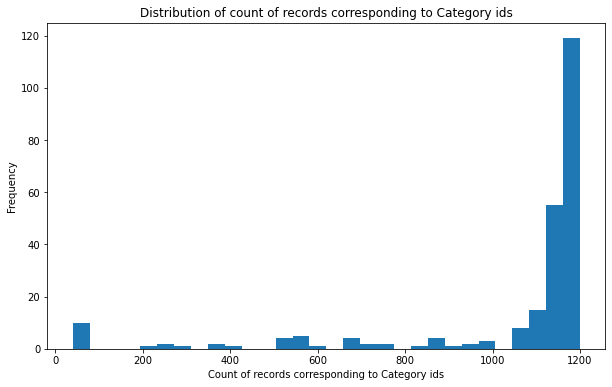

In [4]:
plt.figure(figsize = (10,6))
plt.hist(df_original.category_id.value_counts().values, bins = 30)
plt.title('Distribution of count of records corresponding to Category ids')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

According to the plot above we can see the distribution is left tailed so we can try to feature engineer categories with less than 600 records in them as we need to make sure to decrease the tail as well as keep around 200 categories.

### Split the data (to avoid data leakage)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_original[['clean_title', 'clean_description']], 
                                                    df_original['category_id'], random_state=0, test_size=0.2, 
                                                    stratify = df_original['category_id'])

### Feature Engineering

In [6]:
#Lets get a list of the category ids that have less than 480 records (because the data is split into 80/20)
cat_less = y_train.value_counts().index[y_train.value_counts().values < 480]

In [7]:
df_feature_engineer = X_train.loc[y_train[y_train.isin(cat_less)].index]
df_feature_engineer

,clean_title,clean_description
238510,cycle jersey woman short sleeve top shirt ride...,product description product detail jpojpo cycl...
231915,woman casual summer dress neck floral spaghett...,size dress dress women size dress closure woma...
245505,woman sport short sleeve short paragraph slim ...,fabric polyurethane comfortable breathable swe...
189239,kingshow man warm waterproof winter snow leath...,rubber sole shaft measure ankle high arch prem...
200728,women wide leg cuff hot pant high waiste vinta...,fashion jean short wardrobe hot summer short f...
...,...,...
126937,woman black swarovski handmade jooti designer ...,material fabric amp foam lifestyle ethnic trad...
231789,lucktop woman summer midi dress printing neck ...,spring dress dress women spring dress closure ...
195542,skecher man nampa groton food service shoe,leather synthetic rubber sole shaft measure lo...
127196,kalra creation jutti indian woman traditional ...,faux leather sequence work leather sole india ...


In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
#Extracting the keywords from the cleaned titles
df_feature_engineer['title_keywords'] = df_feature_engineer['clean_title'].apply(lambda x: " ".join([ent.text for ent in nlp(x) if ent.pos_ == 'NOUN']))
df_feature_engineer

,clean_title,clean_description,title_keywords
238510,cycle jersey woman short sleeve top shirt ride...,product description product detail jpojpo cycl...,cycle jersey woman sleeve shirt ride bike bike...
231915,woman casual summer dress neck floral spaghett...,size dress dress women size dress closure woma...,woman summer dress neck spaghetti strap ruffle...
245505,woman sport short sleeve short paragraph slim ...,fabric polyurethane comfortable breathable swe...,woman sport sleeve paragraph yoga clothe suck ...
189239,kingshow man warm waterproof winter snow leath...,rubber sole shaft measure ankle high arch prem...,man winter snow leather boot color size
200728,women wide leg cuff hot pant high waiste vinta...,fashion jean short wardrobe hot summer short f...,women leg cuff waiste vintage denim stretchy r...
...,...,...,...
126937,woman black swarovski handmade jooti designer ...,material fabric amp foam lifestyle ethnic trad...,woman handmade jooti designer punjabi jutti mo...
231789,lucktop woman summer midi dress printing neck ...,spring dress dress women spring dress closure ...,woman summer dress printing neck flowy swing s...
195542,skecher man nampa groton food service shoe,leather synthetic rubber sole shaft measure lo...,skecher man nampa groton food service shoe
127196,kalra creation jutti indian woman traditional ...,faux leather sequence work leather sole india ...,creation jutti woman leather sequence shoe


In [10]:
#Aggregating the keywords for the categories
df_feature_engineer['category_id'] = y_train[y_train.isin(cat_less)]
df_feature_engineer_step = df_feature_engineer[['category_id', 'title_keywords']].groupby('category_id', sort=False, as_index = False).agg(' '.join)
df_feature_engineer_step

,category_id,title_keywords
0,291,cycle jersey woman sleeve shirt ride bike bike...
1,282,woman summer dress neck spaghetti strap ruffle...
2,298,woman sport sleeve paragraph yoga clothe suck ...
3,239,man winter snow leather boot color size arctix...
4,252,women leg cuff waiste vintage denim stretchy r...
5,86,tonsee woman winter hat skiing cap skull beani...
6,197,man cotton nightshirt amp neck sleeve pajama s...
7,169,step style woman cream gold designer pakistani...
8,257,lady man bicycle glove spring autumn glove mot...
9,258,woman lace butterfly print print jean bermuda ...


In [11]:
# vectorize sentences based on tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_feature_engineer_step['title_keywords'])
dic_remap = {}
dic_remap.fromkeys(df_feature_engineer_step.category_id)

# measure similarity between keywords for each category
similarity = np.zeros((df_feature_engineer.category_id.nunique(),df_feature_engineer.category_id.nunique()))

for i in range(df_feature_engineer.category_id.nunique()):
        similarity[i,:] = cosine_similarity(X[i], X[:])
        similarity[i,i] = 0
        dic_remap[df_feature_engineer_step.loc[i,'category_id']] = df_feature_engineer_step.loc[similarity[i].argmax(),'category_id']

In [12]:
#Using dic_remap to remap the categories in training data
y_train.replace(dic_remap, inplace = True)
#Using dic_remap to remap the categories in test data
y_test.replace(dic_remap, inplace = True)

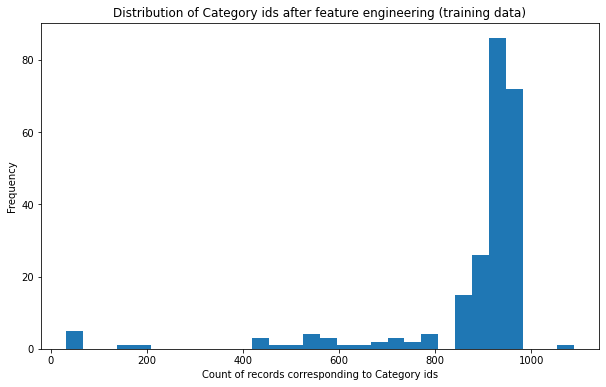

In [13]:
plt.figure(figsize = (10,6))
plt.hist(y_train.value_counts().values, bins = 30)
plt.title('Distribution of Category ids after feature engineering (training data)')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

The intution behind the entire process is to group similar categories together based on the cosine similarity.

Lets drop the categories with less than 480 products in the training data to deal with the imbalance

In [14]:
#Lets get a list of the category ids that have less than 480 records
cat_less_480 = y_train.value_counts().index[y_train.value_counts().values < 480]

In [15]:
X_train = X_train.drop(y_train[y_train.isin(cat_less_480)].index, axis = 0)
X_train

,clean_title,clean_description
194510,acko shoe cover disposable pack pair disposabl...,premium quality high quality cpe material wate...
164961,winter round neck sweater man warm casual loos...,material cotton material wool applicable seaso...
109586,circus sam edelman woman harlee loafer,synthetic sole breathable lining padded insole...
75502,private customize african suit jacket mini ski...,zipper closure grade class fabric african wax ...
8354,yeokou woman baggy neck cotton wide leg jumpsu...,fabric cotton linen machine wash pull closure ...
...,...,...
188045,waterproof man hunt field boot protective foot...,rubber sole waterproof plastic material polyur...
116920,ziitop women snow boot anti slip winter warm f...,anti slip rubber outsole design pattern excell...
187390,man boot winter waterproof ankle boot martin b...,design stylish serrate groove design seam seal...
146699,gioberti man kent lie collar long sleeve tuxed...,cotton polyester drawstre closure delicate cyc...


In [16]:
y_train = y_train.drop(y_train[y_train.isin(cat_less_480)].index)
y_train

194510    246
164961    207
109586    151
75502     114
8354       11
         ... 
188045    237
116920    159
187390    235
146699    190
204438    255
Name: category_id, Length: 200001, dtype: int64

In [17]:
#Implementing the same process on the test data
X_test = X_test.drop(y_test[y_test.isin(cat_less_480)].index, axis = 0)
X_test

,clean_title,clean_description
111971,retro motorcycle woman boot leopard print stit...,italian shoe woman zandalias para mujer de mod...
112565,dragonhoo fashion woman casual shoe breathable...,platform shoe walk shoe summer shoe slip shoe ...
138565,amazon essential man regular fit short sleeve ...,cotton button closure machine wash short sleev...
116965,woman snow boot winter waterproof ankle boot w...,soft winter boot hard boot casual style waterp...
164141,disney men ugly christmas sweater,fiber pull closure machine wash officially lic...
...,...,...
121644,lishan woman ankle strap stiletto open toe san...,rubber sole fashion design gold strappy stilet...
126198,chinese beijing shoe kung fu tai chi shoe rubb...,beije cloth shoe chinese traditional shoe year...
138451,oodji ultra man basic slim fit trouser,polyester viscose spandex zipper closure machi...
240793,top woman fashion woman fashion casual printin...,product description size uk eu bust sleeve len...


In [18]:
y_test = y_test.drop(y_test[y_test.isin(cat_less_480)].index)
y_test

111971    153
112565    153
138565    183
116965    159
164141    207
         ... 
121644    164
126198    168
138451    182
240793    293
253912    288
Name: category_id, Length: 50002, dtype: int64

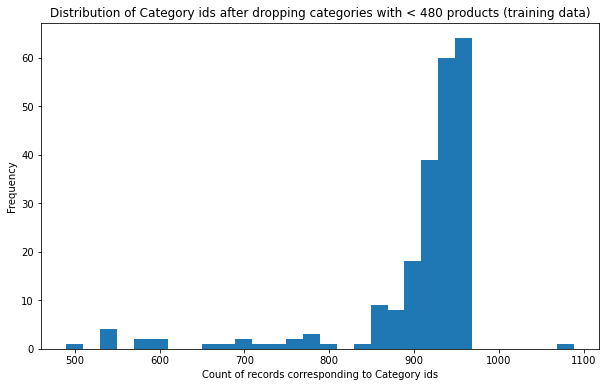

In [19]:
plt.figure(figsize = (10,6))
plt.hist(y_train.value_counts().values, bins = 30)
plt.title('Distribution of Category ids after dropping categories with < 480 products (training data)')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

The distribution looks better than what we had initially. We dropped 2348 records from training dataset because of the condition of more than 480 products for a category id.

### Modeling

In [20]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
vectorizer.fit(X_train['clean_title'].values.astype('U'))
vectorizer1.fit(X_train['clean_description'].values.astype('U'))
X1 = vectorizer.transform(X_train['clean_title'].values.astype('U'))
X2 = vectorizer1.transform(X_train['clean_description'].values.astype('U'))
X_model_train = hstack((X1, X2))

In [22]:
X1_test = vectorizer.transform(X_test['clean_title'].values.astype('U'))
X2_test = vectorizer1.transform(X_test['clean_description'].values.astype('U'))
X_model_test = hstack((X1_test, X2_test))

In [23]:
#Random forest with class weighting in bootstrap samples this is useful for imbalanced data problems
model = RandomForestClassifier(n_estimators = 50, random_state = 0, class_weight='balanced_subsample')
model.fit(X_model_train, y_train)
predictions = model.predict(X_model_test)
print('F1 score on test data from RF model: ', f1_score(y_test, predictions, average = 'micro'))
print('F1 score on train data from RF model: ', f1_score(y_train, model.predict(X_model_train), average = 'micro'))

F1 score on test data from RF model:  0.6824127034918603
F1 score on train data from RF model:  0.9080854595727021


In [24]:
#performing random undersampling of the majority class in each bootstrap sample
model1 = BalancedRandomForestClassifier(n_estimators = 50, random_state = 0)
model1.fit(X_model_train, y_train)
predictions1 = model1.predict(X_model_test)
print('F1 score on test data from RF model with undersampling: ', f1_score(y_test, predictions1, average = 'micro'))
print('F1 score on train data from RF model with undersampling: ', f1_score(y_train, model1.predict(X_model_train), average = 'micro'))

F1 score on test data from RF model with undersampling:  0.6767729290828367
F1 score on train data from RF model with undersampling:  0.9014504927475363
